## **MNIST Autoencoder**

**Imports**

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

**Parameters**

In [2]:
epochs = 50
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE

**Load and Preprocess the Dataset**

In [3]:
(train_dataset, test_dataset), info = tfds.load("mnist", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
def preprocessing(image, label):
  image = tf.cast(image, dtype=tf.float32) / 255
  return image, image

In [5]:
train_dataset = (train_dataset
                 .map(preprocessing)
                 .shuffle(buffer_size, seed=123)
                 .batch(batch_size)
                 .prefetch(AUTOTUNE))

test_dataset = (test_dataset
                .map(preprocessing)
                .batch(batch_size)
                .prefetch(AUTOTUNE))

In [6]:
for im, im2 in train_dataset.take(1):
  print(im.shape)

(128, 28, 28, 1)


In [7]:
im.numpy().min(), im.numpy().max()

(0.0, 1.0)

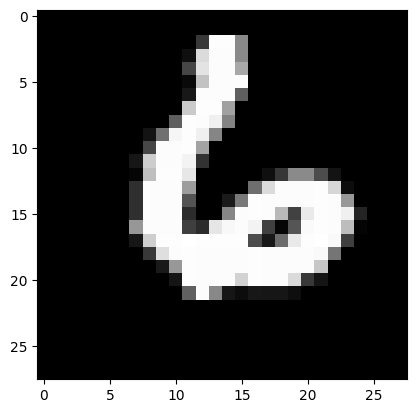

In [8]:
plt.imshow(im[0], cmap="gray");

**Build the Model**

In [9]:
tf.keras.backend.clear_session()

In [10]:
def build_autoencoder():
  # Encoder
  encoder_model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(32, activation="relu")
  ], name="encoder")

  # Autoencoder
  autoencoder_model = tf.keras.Sequential([
      encoder_model,
      # Decoder
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(784, activation="sigmoid"), #Pixel values range from 0 (black) to 1 (white)
      tf.keras.layers.Reshape((28, 28))
  ], name="autoencoder")

  return encoder_model, autoencoder_model

In [11]:
tf.random.set_seed(123) #for reproducibility

encoder_model, autoencoder_model = build_autoencoder()
autoencoder_model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 32)                110816    
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 222384 (868.69 KB)
Trainable params: 222384 (868.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


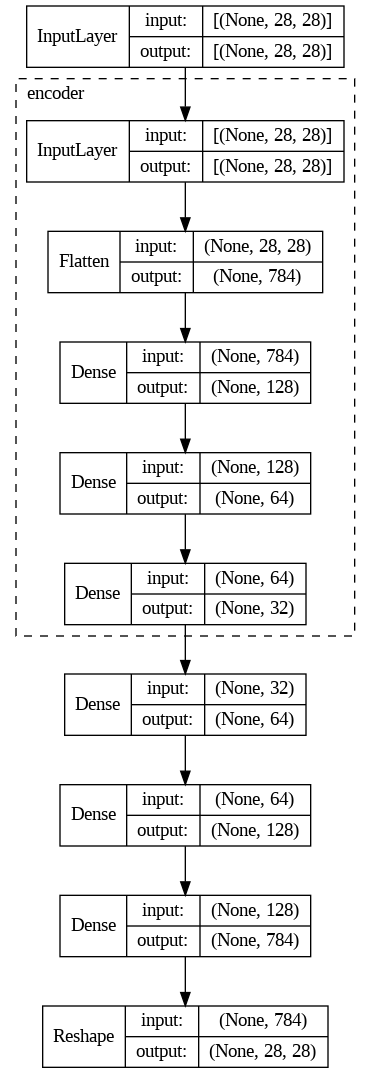

In [12]:
tf.keras.utils.plot_model(autoencoder_model, show_shapes=True, show_layer_names=False, expand_nested=True)

**Compile and Train the Model**

In [13]:
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="binary_crossentropy")

In [14]:
history = autoencoder_model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1)

Epoch 1/50
469/469 [==============================] - 23s 29ms/step - loss: 0.2013 - val_loss: 0.1396
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1306 - val_loss: 0.1210
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1167 - val_loss: 0.1104
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1092 - val_loss: 0.1050
Epoch 5/50
469/469 [==============================] - 5s 10ms/step - loss: 0.1048 - val_loss: 0.1013
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1017 - val_loss: 0.0990
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0990 - val_loss: 0.0965
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0967 - val_loss: 0.0948
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0949 - val_loss: 0.0929
Epoch 10/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0936 - val_loss: 0

In [15]:
# Function to plot the losses
def plot_metrics(history, renderer=None, epochs=epochs):
  losses = history.history["loss"]
  val_losses = history.history["val_loss"]
  list_epochs = np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name="Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name="Val Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"Evolution of Loss across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [16]:
# Interactive graphic
plot_metrics(history)

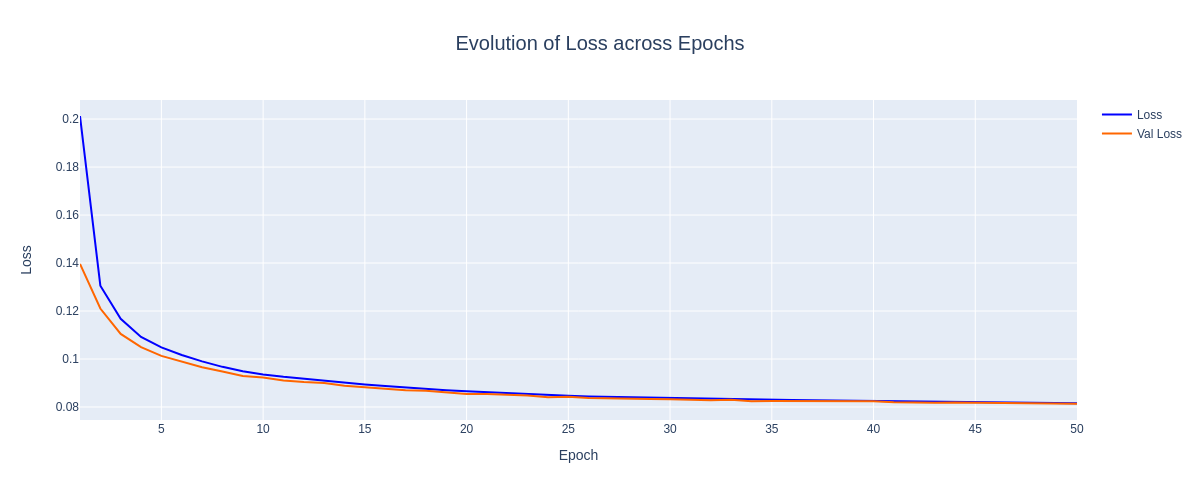

In [17]:
# Image for GitHub
plot_metrics(history, renderer="png")

In [18]:
# Dataset Evaluation
print(autoencoder_model.evaluate(train_dataset))
print(autoencoder_model.evaluate(test_dataset))

469/469 [==============================] - 3s 7ms/step - loss: 0.0815
0.08147499710321426
79/79 [==============================] - 0s 4ms/step - loss: 0.0814
0.08138969540596008


There is no overfitting observed.

**Test set results**

In [19]:
# Get images from test_dataset as numpy arrays
images  = test_dataset.unbatch().map(lambda x, y: x).as_numpy_iterator()
images = np.array(list(images))

images.shape

(10000, 28, 28, 1)

In [20]:
# Predictions
latent_rep = encoder_model.predict(images, batch_size=batch_size, verbose=0)
gen_images = autoencoder_model.predict(images, batch_size=batch_size, verbose=0)

latent_rep.shape, gen_images.shape

((10000, 32), (10000, 28, 28))

In [21]:
# Reshape
latent_rep = tf.reshape(latent_rep, (-1, 8, 4))

In [22]:
names = ["Images", "Latent Representation", "Generated Images"]

In [23]:
# Function to display images

def show_images(images, latent_rep, gen_images, num_examples=25, names=names, random=True, cmap="gray"):

  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(num_examples, 3, figsize=(6, num_examples*2))

  for i in range(num_examples):
    ax[i, 0].imshow(images[indices[i]], cmap="gray")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(latent_rep[indices[i]], cmap="gray")
    ax[i, 1].axis("off")

    ax[i, 2].imshow(gen_images[indices[i]], cmap="gray")
    ax[i, 2].axis("off")

  ax[0, 0].set_title(names[0], fontsize=8, fontweight="bold")
  ax[0, 1].set_title(names[1], fontsize=8, fontweight="bold")
  ax[0, 2].set_title(names[2], fontsize=8, fontweight="bold")

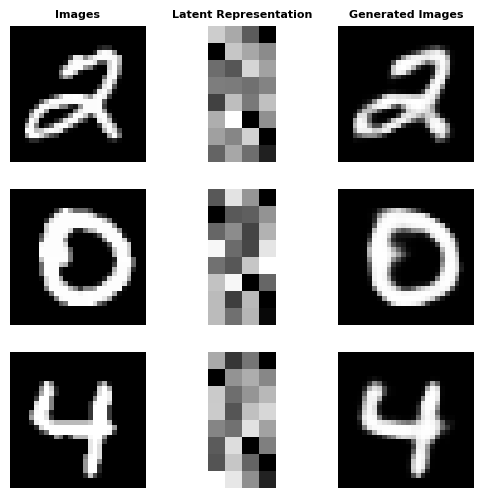

In [24]:
show_images(images, latent_rep, gen_images, random=False, num_examples=3)

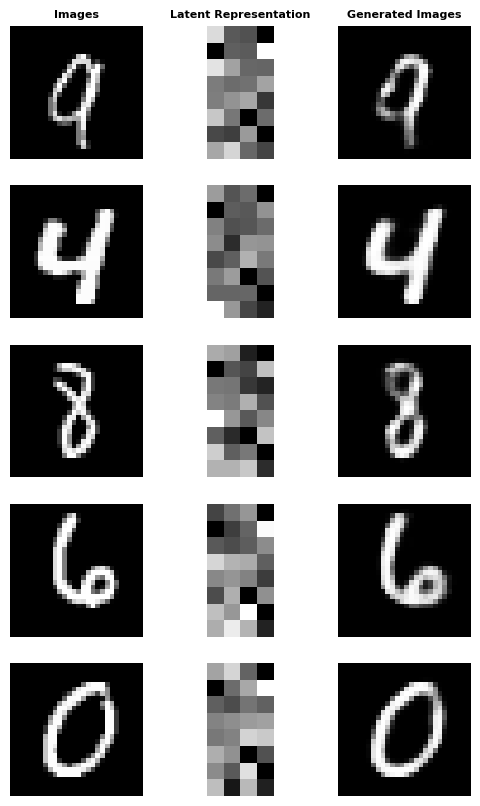

In [25]:
show_images(images, latent_rep, gen_images, num_examples=5)